In [30]:
import numpy as np 
import math 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
import re

In [102]:
class Layer:
    def __init__(self, n_input, n_neuron):
        self.n_input = n_input
        self.n_neuron = n_neuron
        self.std_dev = np.sqrt(1 / n_input) # Xavier initialization
        self.W = np.random.normal(0,self.std_dev,(n_neuron, n_input)) # weight matrix 
        self.b = np.zeros(n_neuron) 
        self.z = np.zeros(n_neuron) # z = Wx + b
        self.a = np.zeros(n_neuron) # a = f(z) 
        self.grad_z = np.zeros(n_neuron) 
        self.grad_a = np.zeros(n_neuron) 
        self.grad_W = np.zeros((n_neuron, n_input)) 
        self.grad_b = np.zeros(n_neuron) 
        
        self.next_layer = None
        self.prev_layer = None
        
        # self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        # self.grad_a_sum = self.grad_a
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b 

        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.z = self.W @ x + self.b  
        self.a = self.activation(self.z) 
    
    def activation(self, z):
        # logistic sigmoid
        # def temp(z) : return max( -500, min( 500, z )) 
        # vec_temp = np.vectorize(temp) 
        # z = vec_temp(z)  

        clipped_z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-clipped_z)) 
    
    def activation_derivative(self, z):
        # derivative of logistic sigmoid
        val = self.activation(z) 
        return val * (1 - val)  

    def compute_grad_a(self):
        if self.next_layer is not None:
            self.grad_a = self.next_layer.W.T @ self.next_layer.grad_z  
            # self.grad_a_sum += self.grad_a 
        else: # output layer
            pass 

    def compute_grad_z(self):
        self.grad_z = self.activation_derivative(self.z) * self.grad_a  # element-wise multiplication 
        # self.grad_z_sum += self.grad_z 

    def compute_grad_W(self):
        if (self.prev_layer is not None):
            self.grad_W = np.outer(self.grad_z, self.prev_layer.a)  
            self.grad_W_sum += self.grad_W 
        else: # input layer
            pass 

    def compute_grad_b(self):
        self.grad_b = self.grad_z 
        self.grad_b_sum += self.grad_b 
    
    def backward(self):
        
        self.compute_grad_a()
        self.compute_grad_z()
        self.compute_grad_W()
        self.compute_grad_b()
        

    def weight_update(self, learning_rate, batch_size):
        # update parameters 
        self.W -= learning_rate * self.grad_W_sum / batch_size
        self.b -= learning_rate * self.grad_b_sum / batch_size
        # self.a -= learning_rate * self.grad_a_sum / batch_size 
        # self.z -= learning_rate * self.grad_z_sum / batch_size 

        # self.grad_z_sum = np.zeros(self.n_neuron) 
        # self.grad_a_sum = np.zeros(self.n_neuron) 
        self.grad_W_sum = np.zeros((self.n_neuron, self.n_input)) 
        self.grad_b_sum = np.zeros(self.n_neuron)  

class InputLayer:
    def __init__(self, n_input):
        self.n_input = n_input
        self.n_neuron = n_input
        self.a = np.zeros(n_input) 
        self.next_layer = None
        self.prev_layer = None 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.a = x 

In [103]:
class OutputLayer:
    def __init__(self, n_input, n_classes):
        self.n_input = n_input
        self.n_classes = n_classes
        self.std_dev = np.sqrt(1 / n_input) # Xavier initialization
        self.W = np.random.normal(0,self.std_dev,(n_classes, n_input)) # weight matrix 
        self.b = np.zeros(n_classes) 
        self.z = np.zeros(n_classes) # z = Wx + b
        self.grad_z = np.zeros(n_classes) 
        self.grad_W = np.zeros((n_classes, n_input)) 
        self.grad_b = np.zeros(n_classes) 

        # self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b
        
        self.batch_loss = 0 
        self.phi = np.zeros(n_classes) # softmax(z) 
        self.next_layer = None
        self.prev_layer = None
        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.z = self.W @ x + self.b  
        self.phi = self.softmax(self.z)  
    
    def softmax(self, z):
        # def temp(z) : return max( -500, min( 500, z )) 
        # vec_temp = np.vectorize(temp) 
        # z = vec_temp(z) 
        z = np.clip(z, -500, 500) 
        return np.exp(z) / np.sum(np.exp(z)) 

    def compute_loss(self, y):
        self.batch_loss -= np.log(self.phi[y])  
    
    def compute_grad_z(self, y):
        self.grad_z = self.phi 
        self.grad_z[y] -= 1
        # self.grad_z_sum += self.grad_z 
    
    def compute_grad_W(self):
        if (self.prev_layer is not None):
            self.grad_W = np.outer(self.grad_z, self.prev_layer.a) 
            self.grad_W_sum += self.grad_W 
        else: # input layer
            pass 
    
    def compute_grad_b(self):
        self.grad_b = self.grad_z
        self.grad_b_sum += self.grad_b
    
    def backward(self, y):
        
        self.compute_grad_z(y)
        self.compute_grad_W()
        self.compute_grad_b() 
    
    def weight_update(self, learning_rate, batch_size):
        # update parameters 
        self.W -= learning_rate * self.grad_W_sum / batch_size
        self.b -= learning_rate * self.grad_b_sum / batch_size
        # self.z -= learning_rate * self.grad_z_sum / batch_size 
        self.loss = self.batch_loss

        self.grad_W_sum = np.zeros((self.n_classes, self.n_input)) 
        self.grad_b_sum = np.zeros(self.n_classes)
        # self.grad_z_sum = np.zeros(self.n_classes) 
        self.batch_loss = 0 
        

In [104]:
class Neural_Network:
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        self.M = minibatch_size 
        self.n = no_of_features
        self.hidden_layers = hidden_layers 
        self.K = no_of_classes 
        self.training_data = None # should be already processed
        self.training_labels = None # should be already processed
        self.network = np.array([]) # array of layers 
        
    def make_network(self):
        input_layer = InputLayer(self.n) 
        self.network = np.append(self.network, input_layer) 
        for i in range(len(self.hidden_layers)):
            new_layer = Layer(self.network[-1].n_neuron, self.hidden_layers[i]) 
            new_layer.set_prev_layer(self.network[-1]) 
            self.network = np.append(self.network, new_layer) 
        
        output_layer = OutputLayer(self.network[-1].n_neuron, self.K) 
        output_layer.set_prev_layer(self.network[-1]) 
        self.network = np.append(self.network, output_layer) 
        print(f"printing network: {self.network}") 

    def forward_prop(self, x):
        self.network[0].forward(x) 
        for i in range(1, len(self.network)):
            self.network[i].forward(self.network[i-1].a) 
    
    def backward_prop(self, y):
        self.network[-1].compute_loss(y) 
        self.network[-1].backward(y) 
        for i in range(len(self.network)-2, 0, -1):
            self.network[i].backward()
    
    def weight_update(self, learning_rate):
        for i in range(1, len(self.network)):
            self.network[i].weight_update(learning_rate, self.M) 
        
    
    def shuffle(self, training_data, training_labels):
        idxs = np.array([i for i in range(len(training_data))]) 
        idx = np.random.shuffle(idxs)
        # print("shuffled idx is ", idxs) 
        training_data = training_data[idxs]
        training_labels = training_labels[idxs]
        return (training_data, training_labels)

    def train(self, training_eg, labels, learning_rate):
        self.training_eg, self.training_labels = self.shuffle(training_eg, labels)  
        # self.validation_split() 
        batches = len(self.training_eg) // self.M 
        self.training_eg = self.training_eg[:batches * self.M] 
        self.training_labels = self.training_labels[:batches * self.M] 
        # max_epochs = 1000
        max_epochs = 100
        epoch, cnt = 0, 0  
        tolerance, max_n_of_iter= 0.0001, 5 
        loss, prev_loss = 0,0
        n_of_iter = 0 
        while(n_of_iter < max_n_of_iter and epoch < max_epochs):
            for i in range(1, len(self.training_eg) + 1):
                self.forward_prop(self.training_eg[i - 1]) 
                self.backward_prop(int(self.training_labels[i - 1])) 
                cnt += 1 
                if (cnt % self.M == 0):
                    self.weight_update(learning_rate)  
                    cnt = 0 
            print(f"epoch {epoch} completed") 
            loss = self.network[-1].loss / self.M 
            print(f"loss is {loss}") 
            epoch += 1 
            if (abs(loss - prev_loss) < tolerance):
                n_of_iter += 1
            else : 
                n_of_iter = 0 

    def predict(self, x):
        self.forward_prop(x) 
        return np.argmax(self.network[-1].phi) 

    def compute_predictions(self, egs):
        correct = 0 
        predictions = [] 
        for i in range(len(egs)): predictions.append(self.predict(egs[i])) 
        return predictions

    def validation_split(self):
        validation_split_percent = 0.25 
        split = int(validation_split_percent * len(self.training_data)) 
        validation_eg = self.training_data[:split]
        self.training_eg = self.training_data[split:] 
        self.validation_eg = validation_eg 
        self.training_labels = self.training_labels[split:] 
        self.validation_labels = self.training_labels[:split] 
        return  
        

In [31]:
def get_input(input_path, output_path):
    x = np.load(input_path)
    y = np.load(output_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x,y

In [32]:
X_train, Y_train = get_input("../data/part b/x_train.npy", "../data/part b/y_train.npy") 
X_test, Y_test = get_input("../data/part b/x_test.npy", "../data/part b/y_test.npy" )
print(X_test.shape) 
print(Y_test.shape)
Y_train = Y_train - 1 
Y_test = Y_test - 1 

(1000, 1024)
(1000,)


In [107]:
# experimenting for part b 
# hidden_layers = np.array([[1], [5], [10], [50], [100]])
hidden_layers = [] 
nn_list = [] 
for hidden_layer in hidden_layers:
    nn = Neural_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.01) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

In [34]:
# plot by reading from logfile
def read_logfile(name):
    hidden_layer_sizes = [] 
    train_recall, test_recall = [[] for i in range(5)], [[] for i in range(5)] 
    train_precision, test_precision = [[] for i in range(5)], [[] for i in range(5)] 
    train_f1, test_f1 = [[] for i in range(5)], [[] for i in range(5)] 
    train_acc, test_acc= [], [] 
    in_train, in_test = False, False 
    with open(name, "r") as file:
        report = "" 
        lines = file.readlines()
        for line in lines:
            line = line.lstrip() 
            if (line.startswith("hidden_layer")):
                size = re.findall(r'\d+', line) 
                hidden_layer_sizes.append(int(size[0])) 
            elif (line.startswith("printing train report")):
                in_train = True
                in_test = False 
            elif (line.startswith("printing test report")):
                in_test = True 
                in_train = False

            elif (line.startswith("accuracy")):
                if (in_train):
                    acc = re.findall(r'\d+\.\d+', line)[0]
                    train_acc.append(float(acc))  
                elif (in_test):
                    acc = re.findall(r'\d+\.\d+', line)[0] 
                    test_acc.append(float(acc)) 

            elif (line.startswith("macro avg") or line.startswith("weighted avg")):
                continue 
            
            else:
                vals = re.findall(r'\d+\.\d+', line)
                if (len(vals) == 0): continue
                label = int(float(vals[0]))
                if (in_train):
                    train_recall[label].append(float(vals[2])) 
                    train_precision[label].append(float(vals[1])) 
                    train_f1[label].append(float(vals[3])) 
                elif (in_test):
                    test_recall[label].append(float(vals[2])) 
                    test_precision[label].append(float(vals[1])) 
                    test_f1[label].append(float(vals[3])) 
    return (hidden_layer_sizes, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)
    

def plot_accuracies(y_lines, x, labels, x_label, y_label, name):

    fig,axis = plt.subplots()
    for y_line,label  in zip(y_lines, labels):
        axis.plot(x, y_line, label = label, marker='o', markersize=5) 
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.legend()
    plt.grid(True)
    plt.savefig(f"{name}.pdf")
    plt.show()

def get_latex_code(hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc):

    # hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = 
    # read_logfile(logfile)  
    archs = ["{{512}}", "{{512, 256}}", "{{512, 256, 128}}", "{{512, 256, 128, 64}}"] 
    s = ""
    for i in range (len(hidden_layers)):
        s += f""" 
\\begin{{table}}[H]
    \\centering
    \\caption{{Train data : Architecture {archs[i]}}} 
    \\large
    \\begin{{tabularx}}{{0.7\\textwidth}}{{XXXX}}
    \\toprule
        & Precision & Recall & F1 score \\\\
    \\midrule
    class 0 & {train_precision[0][i]} & {train_recall[0][i]} & {train_f1[0][i]} \\\\
    class 1 & {train_precision[1][i]} & {train_recall[1][i]} & {train_f1[1][i]} \\\\
    class 2 & {train_precision[2][i]} & {train_recall[2][i]} & {train_f1[2][i]} \\\\
    class 3 & {train_precision[3][i]} & {train_recall[3][i]} & {train_f1[3][i]} \\\\
    class 4 & {train_precision[4][i]} & {train_recall[4][i]} & {train_f1[4][i]} \\\\
    \\bottomrule
    \\end{{tabularx}}
\\end{{table}}

\\begin{{table}}[H]
    \\centering
    \\caption{{Test data : Architecture {archs[i]} }}  
    \\large
    \\begin{{tabularx}}{{0.7\\textwidth}}{{XXXX}}
    \\toprule
        & Precision & Recall & F1 score \\\\
    \\midrule
    class 0 & {test_precision[0][i]} & {test_recall[0][i]} & {test_f1[0][i]} \\\\
    class 1 & {test_precision[1][i]} & {test_recall[1][i]} & {test_f1[1][i]} \\\\
    class 2 & {test_precision[2][i]} & {test_recall[2][i]} & {test_f1[2][i]} \\\\
    class 3 & {test_precision[3][i]} & {test_recall[3][i]} & {test_f1[3][i]} \\\\
    class 4 & {test_precision[4][i]} & {test_recall[4][i]} & {test_f1[4][i]} \\\\
    \\bottomrule
    \\end{{tabularx}}
\\end{{table}}
"""

    print(s) 




 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.97 & 0.94 & 0.95 \\
    class 1 & 0.84 & 0.82 & 0.83 \\
    class 2 & 0.63 & 0.72 & 0.67 \\
    class 3 & 0.59 & 0.62 & 0.6 \\
    class 4 & 0.84 & 0.76 & 0.8 \\
    \bottomrule
    \end{tabularx}
\end{table}

\begin{table}[H]
    \centering
    \caption{Test data : Architecture {{512}} }  
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.96 & 0.96 & 0.96 \\
    class 1 & 0.8 & 0.78 & 0.79 \\
    class 2 & 0.59 & 0.68 & 0.63 \\
    class 3 & 0.63 & 0.58 & 0.6 \\
    class 4 & 0.78 & 0.74 & 0.76 \\
    \bottomrule
    \end{tabularx}
\end{table}
 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512, 256}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}

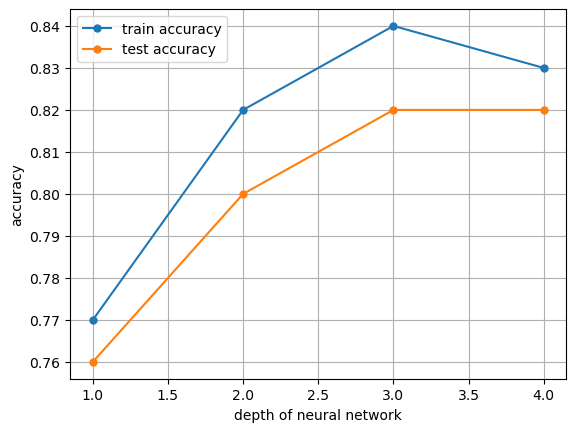

[0.77  0.816 0.834 0.83 ]
[[0.95 0.98 0.98 0.98]
 [0.83 0.89 0.92 0.91]
 [0.67 0.76 0.8  0.8 ]
 [0.6  0.64 0.65 0.64]
 [0.8  0.81 0.82 0.82]]


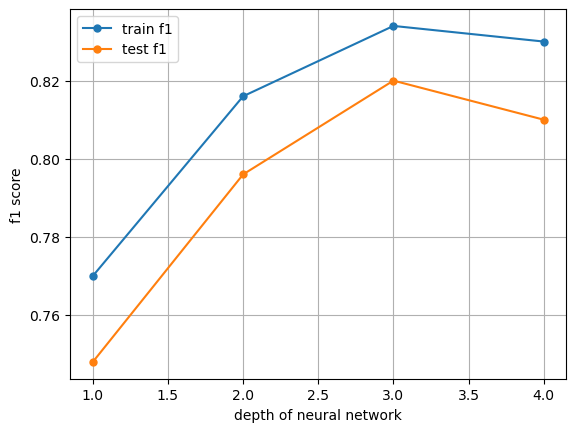

In [41]:
hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = read_logfile("logfile_part_c")
get_latex_code(hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)

depths = [1,2,3,4]

# plotting train and test accuracies 
plot_accuracies([train_acc, test_acc], depths, ["train accuracy", "test accuracy"],"depth of neural network", "accuracy", "partc_accuracies") 
train_f1 = np.array(train_f1) 
train_f1_avg = np.mean(train_f1, axis = 0) 
test_f1 = np.array(test_f1)
test_f1_avg = np.mean(test_f1, axis = 0)
print(train_f1_avg)
print(train_f1) 
plot_accuracies([train_f1_avg, test_f1_avg], depths, ["train f1", "test f1"], "depth of neural network", "f1 score", "partc_f1")



 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.9 & 0.87 & 0.88 \\
    class 1 & 0.69 & 0.69 & 0.69 \\
    class 2 & 0.54 & 0.56 & 0.55 \\
    class 3 & 0.46 & 0.5 & 0.48 \\
    class 4 & 0.75 & 0.7 & 0.72 \\
    \bottomrule
    \end{tabularx}
\end{table}

\begin{table}[H]
    \centering
    \caption{Test data : Architecture {{512}} }  
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.91 & 0.9 & 0.9 \\
    class 1 & 0.67 & 0.67 & 0.67 \\
    class 2 & 0.51 & 0.56 & 0.53 \\
    class 3 & 0.52 & 0.48 & 0.5 \\
    class 4 & 0.68 & 0.68 & 0.68 \\
    \bottomrule
    \end{tabularx}
\end{table}
 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512, 256}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
 

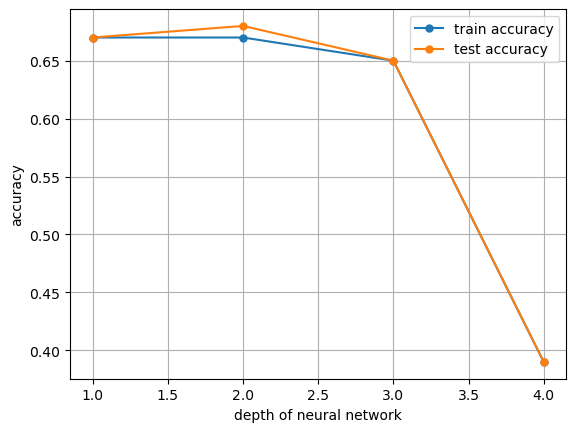

[0.664 0.668 0.644 0.262]
[[0.88 0.88 0.88 0.77]
 [0.69 0.69 0.66 0.  ]
 [0.55 0.55 0.52 0.08]
 [0.48 0.49 0.45 0.  ]
 [0.72 0.73 0.71 0.46]]


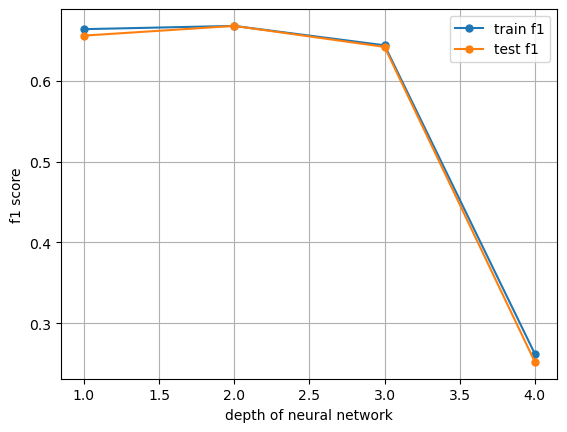

In [36]:
hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = read_logfile("logfile_part_d")
get_latex_code(hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)

depths = [1,2,3,4]

# plotting train and test accuracies 
plot_accuracies([train_acc, test_acc], depths, ["train accuracy", "test accuracy"],"depth of neural network", "accuracy", "partd_accuracies") 
train_f1 = np.array(train_f1) 
train_f1_avg = np.mean(train_f1, axis = 0) 
test_f1 = np.array(test_f1)
test_f1_avg = np.mean(test_f1, axis = 0)
print(train_f1_avg)
print(train_f1) 
plot_accuracies([train_f1_avg, test_f1_avg], depths, ["train f1", "test f1"], "depth of neural network", "f1 score", "partd_f1")



 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.91 & 0.89 & 0.9 \\
    class 1 & 0.73 & 0.72 & 0.73 \\
    class 2 & 0.62 & 0.61 & 0.61 \\
    class 3 & 0.52 & 0.59 & 0.55 \\
    class 4 & 0.8 & 0.74 & 0.77 \\
    \bottomrule
    \end{tabularx}
\end{table}

\begin{table}[H]
    \centering
    \caption{Test data : Architecture {{512}} }  
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.92 & 0.91 & 0.91 \\
    class 1 & 0.69 & 0.7 & 0.7 \\
    class 2 & 0.56 & 0.51 & 0.58 \\
    class 3 & 0.56 & 0.52 & 0.54 \\
    class 4 & 0.71 & 0.7 & 0.71 \\
    \bottomrule
    \end{tabularx}
\end{table}
 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512, 256}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}


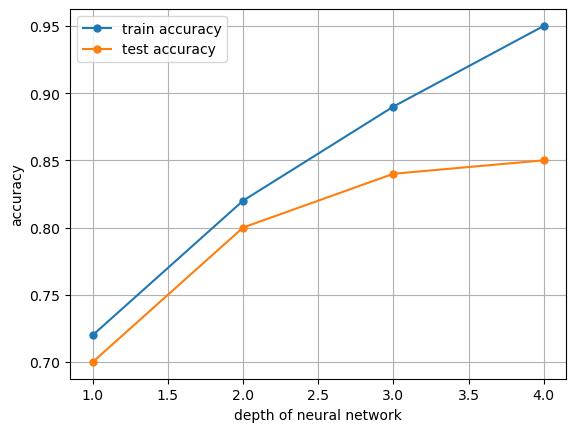

[0.712 0.816 0.884 0.944]
[[0.9  0.98 0.99 0.99]
 [0.73 0.88 0.95 0.97]
 [0.61 0.76 0.87 0.93]
 [0.55 0.65 0.73 0.89]
 [0.77 0.81 0.88 0.94]]


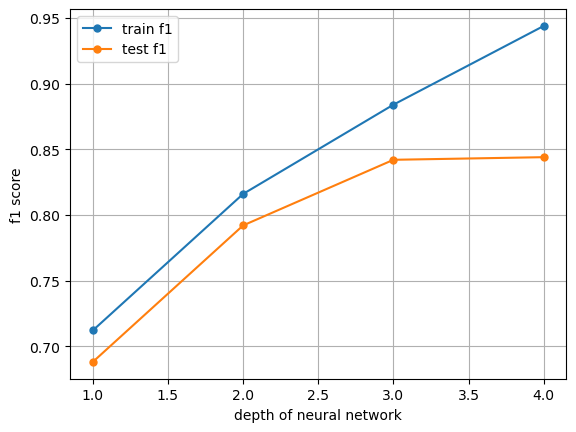

In [40]:
hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = read_logfile("logfile_part_e")
get_latex_code(hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)

depths = [1,2,3,4]

# plotting train and test accuracies 
plot_accuracies([train_acc, test_acc], depths, ["train accuracy", "test accuracy"],"depth of neural network", "accuracy", "parte_accuracies") 
train_f1 = np.array(train_f1) 
train_f1_avg = np.mean(train_f1, axis = 0) 
test_f1 = np.array(test_f1)
test_f1_avg = np.mean(test_f1, axis = 0)
print(train_f1_avg)
print(train_f1) 
plot_accuracies([train_f1_avg, test_f1_avg], depths, ["train f1", "test f1"], "depth of neural network", "f1 score", "parte_f1")



 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.86 & 0.89 & 0.88 \\
    class 1 & 0.68 & 0.68 & 0.68 \\
    class 2 & 0.54 & 0.53 & 0.54 \\
    class 3 & 0.5 & 0.45 & 0.47 \\
    class 4 & 0.7 & 0.74 & 0.72 \\
    \bottomrule
    \end{tabularx}
\end{table}

\begin{table}[H]
    \centering
    \caption{Test data : Architecture {{512}} }  
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
    \toprule
        & Precision & Recall & F1 score \\
    \midrule
    class 0 & 0.9 & 0.9 & 0.9 \\
    class 1 & 0.65 & 0.64 & 0.65 \\
    class 2 & 0.54 & 0.51 & 0.52 \\
    class 3 & 0.49 & 0.51 & 0.5 \\
    class 4 & 0.69 & 0.7 & 0.69 \\
    \bottomrule
    \end{tabularx}
\end{table}
 
\begin{table}[H]
    \centering
    \caption{Train data : Architecture {{512, 256}}} 
    \large
    \begin{tabularx}{0.7\textwidth}{XXXX}
  

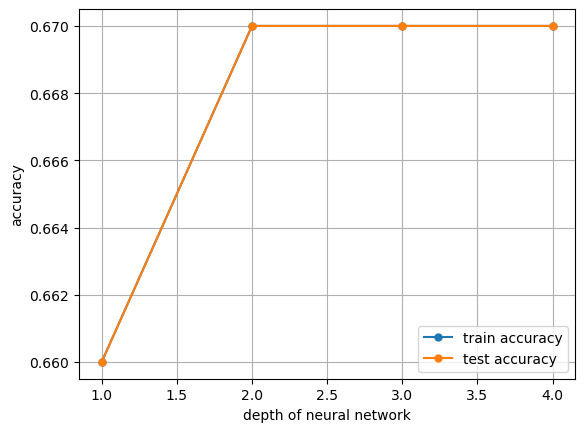

[0.658 0.666 0.666 0.664]
[[0.88 0.88 0.89 0.88]
 [0.68 0.69 0.69 0.69]
 [0.54 0.55 0.55 0.55]
 [0.47 0.49 0.48 0.48]
 [0.72 0.72 0.72 0.72]]


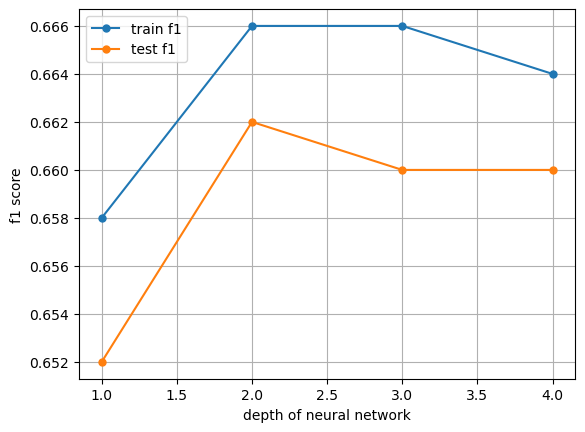

In [43]:
hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = read_logfile("logfile_part_f")
get_latex_code(hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)

depths = [1,2,3,4]

# plotting train and test accuracies 
plot_accuracies([train_acc, test_acc], depths, ["train accuracy", "test accuracy"],"depth of neural network", "accuracy", "partf_accuracies") 
train_f1 = np.array(train_f1) 
train_f1_avg = np.mean(train_f1, axis = 0) 
test_f1 = np.array(test_f1)
test_f1_avg = np.mean(test_f1, axis = 0)
print(train_f1_avg)
print(train_f1) 
plot_accuracies([train_f1_avg, test_f1_avg], depths, ["train f1", "test f1"], "depth of neural network", "f1 score", "partf_f1")



## Comments
We see that f1 score is a good measure of generalization accuracy, since plots of test f1 score and test accuracy follow the same trend. Same holds for test data. 

In general, increasing the hidden layer size increases the test accuracy and test f1 score. 

We also observe that increasing the hidden layer size doesn't necessariliy increase f1 score. This could be due to overfitting of the model and loss of generalization accuracy with overly complex model . 

In [110]:
# experimenting for part b 
hidden_layers = [[512, 256, 128], [512, 256, 128, 64]] 
nn_list = [] 
for hidden_layer in hidden_layers:
    nn = Neural_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.05) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile_part_c", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

printing network: [<__main__.InputLayer object at 0x0000013527A28150>


KeyboardInterrupt: 

In [ ]:
class AdaptiveNeuralNetwork(Neural_Network):
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        super().__init__(minibatch_size, no_of_features, hidden_layers, no_of_classes) 
        
    
    def train(self, training_eg, labels, seed):
        # adaptive learning rate = seed / sqrt(epoch) 
        self.training_eg, self.training_labels = self.shuffle(training_eg, labels)  
        # self.validation_split() 
        batches = len(self.training_eg) // self.M 
        self.training_eg = self.training_eg[:batches * self.M] 
        self.training_labels = self.training_labels[:batches * self.M] 
        # max_epochs = 1000
        max_epochs = 200 
        epoch, cnt = 0, 0  
        tolerance_seed, max_n_of_iter= 0.0001, 5 
        loss, prev_loss = 0,0
        n_of_iter = 0 
        while(n_of_iter < max_n_of_iter and epoch < max_epochs):
            for i in range(1, len(self.training_eg) + 1):
                self.forward_prop(self.training_eg[i - 1]) 
                self.backward_prop(int(self.training_labels[i - 1])) 
                cnt += 1 
                if (cnt % self.M == 0):
                    self.weight_update(seed / math.sqrt(epoch + 1))    
                    cnt = 0 
            print(f"epoch {epoch} completed") 
            loss = self.network[-1].loss / self.M 
            print(f"loss is {loss}") 
            epoch += 1 
            tolerance = tolerance_seed/ math.sqrt(epoch) 
            if (abs(loss - prev_loss) < tolerance):
                n_of_iter += 1
            else : 
                n_of_iter = 0 

In [ ]:
class RelU_Layer(Layer):
    def __init__(self, n_input, n_neuron):
        self.n_input = n_input
        self.n_neuron = n_neuron
        self.std_dev = np.sqrt(2 / n_input) # Xavier initialization for RelU 
        self.W = np.random.normal(0,self.std_dev,(n_neuron, n_input)) # weight matrix 
        self.b = np.zeros(n_neuron) 
        self.z = np.zeros(n_neuron) # z = Wx + b
        self.a = np.zeros(n_neuron) # a = f(z) 
        self.grad_z = np.zeros(n_neuron) 
        self.grad_a = np.zeros(n_neuron) 
        self.grad_W = np.zeros((n_neuron, n_input)) 
        self.grad_b = np.zeros(n_neuron) 
        
        self.next_layer = None
        self.prev_layer = None
        
        # self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        # self.grad_a_sum = self.grad_a
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b 

        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
       
    def temp(self, z) : return max( 0, z )

    def activation(self, z):
        # RelU 
        vec_temp = np.vectorize(self.temp) 
        return vec_temp(z) 
    
    def temp2(self, val) :
        if (val > 0): return 1 
        elif (val == 0): return 0.5 
        else : return 0  

    def activation_derivative(self, z):
        # derivative of logistic sigmoid
        vec_temp = np.vectorize(self.temp2) 
        return vec_temp(z)   

class RelU_OutputLayer(OutputLayer):
    def softmax(self, z):
        z = z - np.max(z) 
        try : return np.exp(z) / np.sum(np.exp(z)) 
        except OverflowError:
            def temp(z) : return max( -500, min( 500, z )) 
            vec_temp = np.vectorize(temp) 
            z = vec_temp(z) 
            return np.exp(z) / np.sum(np.exp(z)) 

class RelU_Network(AdaptiveNeuralNetwork):
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        super().__init__(minibatch_size, no_of_features, hidden_layers, no_of_classes) 
    
    def make_network(self):
        input_layer = InputLayer(self.n) 
        self.network = np.append(self.network, input_layer) 
        for i in range(len(self.hidden_layers)):
            new_layer = RelU_Layer(self.network[-1].n_neuron, self.hidden_layers[i]) 
            new_layer.set_prev_layer(self.network[-1]) 
            self.network = np.append(self.network, new_layer) 
        
        output_layer = OutputLayer(self.network[-1].n_neuron, self.K) 
        output_layer.set_prev_layer(self.network[-1]) 
        self.network = np.append(self.network, output_layer) 
        print(f"printing network: {self.network}")

In [ ]:
# experimenting for part d 
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]] 
nn_list_2 = [] 
for hidden_layer in hidden_layers:
    nn = AdaptiveNeuralNetwork(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.05) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile_part_d", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

In [112]:
# experimenting for part e 
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]] 
nn_list_2 = [] 
for hidden_layer in hidden_layers:
    nn = RelU_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.01) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile_part_e", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

printing network: [<__main__.InputLayer object at 0x0000013519B08450>


epoch 0 completed
loss is 1.1634362717446287
epoch 1 completed
loss is 1.0421711590669818
epoch 2 completed
loss is 0.9882724705336914
epoch 3 completed
loss is 0.9576992774194737
epoch 4 completed
loss is 0.9361892538548519
epoch 5 completed
loss is 0.9205220986122236
epoch 6 completed
loss is 0.9082003783432652
epoch 7 completed
loss is 0.8981425249116415
epoch 8 completed
loss is 0.8898478337784206
epoch 9 completed
loss is 0.88300209749757
epoch 10 completed
loss is 0.876988406412143
epoch 11 completed
loss is 0.8715077497017442
epoch 12 completed
loss is 0.8666988308686637
epoch 13 completed
loss is 0.8622710131208496
epoch 14 completed
loss is 0.8581945410042062
epoch 15 completed
loss is 0.8545754085254933
epoch 16 completed
loss is 0.851182883726767
epoch 17 completed
loss is 0.8480054096256642
epoch 18 completed
loss is 0.8449216323441634
epoch 19 completed
loss is 0.8420428354296499
epoch 20 completed
loss is 0.839404199909243
epoch 21 completed
loss is 0.8368824910034629
epo

KeyboardInterrupt: 

### Scikit Learn MLP classifier

In [42]:
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]] 
for hidden_layer in hidden_layers:
    scikit_nn = MLPClassifier(hidden_layer_sizes= hidden_layer , activation='relu', solver='sgd', batch_size=32, alpha=0, 
                                learning_rate="invscaling", max_iter=200, learning_rate_init=0.01 ,verbose = True)
    scikit_nn.fit(X_train, Y_train) 
    train_pred = scikit_nn.predict(X_train) 
    test_pred = scikit_nn.predict(X_test)
    report_test = classification_report( Y_test, test_pred) 
    report_train = classification_report(Y_train, train_pred)
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print()
    print()
    with open("logfile_part_f", "a") as file:
        file.write(to_print) 
    


Iteration 1, loss = 0.96478549
Iteration 2, loss = 0.82516945
Iteration 3, loss = 0.76812418
Iteration 4, loss = 0.76722553
Iteration 5, loss = 0.76625939
Iteration 6, loss = 0.76564881
Iteration 7, loss = 0.76516596
Iteration 8, loss = 0.76459338
Iteration 9, loss = 0.76450382
Iteration 10, loss = 0.76402756
Iteration 11, loss = 0.76367589
Iteration 12, loss = 0.76333018
Iteration 13, loss = 0.76306490
Iteration 14, loss = 0.76283095
Iteration 15, loss = 0.76254821
Iteration 16, loss = 0.76233536
Iteration 17, loss = 0.76213502
Iteration 18, loss = 0.76187373
Iteration 19, loss = 0.76166524
Iteration 20, loss = 0.76145215
Iteration 21, loss = 0.76139094
Iteration 22, loss = 0.76105568
Iteration 23, loss = 0.76091925
Iteration 24, loss = 0.76076460
Iteration 25, loss = 0.76067379
Iteration 26, loss = 0.76047446
Iteration 27, loss = 0.76028110
Iteration 28, loss = 0.76016273
Iteration 29, loss = 0.75991303
Iteration 30, loss = 0.75975998
Iteration 31, loss = 0.75971097
Iteration 32, los

c:\Users\surbh\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
